<a href="https://colab.research.google.com/github/FatmaBouzghaia/Offline_Signature_Verification_Using_Siamese_Model/blob/master/SiameseModel_CEDAR_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
import keras.backend.tensorflow_backend as tfback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [ ]:
print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


In [ ]:
!cp -r "/content/drive/My Drive/projetCassiopee/CEDAR/signatures/" "/content/sample_data/"

KeyboardInterrupt: ignored

In [ ]:
# Path to BHSig260 Hindi dataset
path_Hindi = "/content/drive/My Drive/projetCassiopee/BHSig260/Hindi/"
# Path to BHSig260 Bengali dataset
path_Bengali = "/content/drive/My Drive/projetCassiopee/BHSig260/Bengali/"
#Path to GPDS960 dataset
path_GPDS = "/content/drive/My Drive/projetCassiopee/firmasGPDS960bw300/"
#Path to DS2-Get dataset
path_DS2 = "/content/drive/My Drive/projetCassiopee/DS2-GET/"
# Path to CEDAR dataset
path_CEDAR = "/content/drive/My Drive/projetCassiopee/CEDAR/signatures/"

## **Training on the CEDAR dataset**

In [ ]:
# Get the list of all directories and sort them
dir_list_CEDAR = next(os.walk(path_CEDAR))[1]
dir_list_CEDAR.sort()

In [ ]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
from natsort import natsorted, ns
orig_groups_CEDAR, forg_groups_CEDAR = [], []
# for directory in dir_list_CEDAR:
 #   images = os.listdir(path_CEDAR+directory)
 #   images.sort()
  #  images = [path+directory+'/'+x for x in images]
   # forg_groups_CEDAR.append(images[:30]) # First 30 signatures in each folder are forrged
    #orig_groups_CEDAR.append(images[30:]) # Next 24 signatures are genuine

orig_groups_CEDAR_tmp = os.listdir(path_CEDAR+"full_org")
forg_groups_CEDAR_tmp = os.listdir(path_CEDAR+"full_forg")
orig_groups_CEDAR_tmp.sort();
forg_groups_CEDAR_tmp.sort();
orig_groups_CEDAR = [orig_groups_CEDAR_tmp[i*24:(i+1)*24] for i in range(55) ];
forg_groups_CEDAR = [forg_groups_CEDAR_tmp[i*24:(i+1)*24] for i in range(55) ];


In [ ]:
# Quick check to confirm we have data of all the 55 individuals
len(orig_groups_CEDAR), len(forg_groups_CEDAR)

(55, 55)

In [ ]:
orig_lengths_CEDAR = [len(x) for x in orig_groups_CEDAR]
forg_lengths_CEDAR = [len(x) for x in forg_groups_CEDAR]

In [ ]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths_CEDAR)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [ ]:
# Quick check to confirm that there are 24 Forged signatures for each individual
print(forg_lengths_CEDAR)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [ ]:
orig_train_CEDAR, orig_val_CEDAR, orig_test_CEDAR = orig_groups_CEDAR[:35], orig_groups_CEDAR[35:45], orig_groups_CEDAR[45:]
forg_train_CEDAR, forg_val_CEDAR, forg_test_CEDAR = forg_groups_CEDAR[:35], forg_groups_CEDAR[35:45], forg_groups_CEDAR[45:]

In [ ]:
# Delete unnecessary variables
del orig_groups_CEDAR, forg_groups_CEDAR, orig_groups_CEDAR_tmp, forg_groups_CEDAR_tmp

In [ ]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [ ]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train_CEDAR))
    orig_img_names = random.sample(orig_train_CEDAR[k], 2)
    forg_img_name = random.sample(forg_train_CEDAR[k], 1)
    orig_img1 = cv2.imread(path_CEDAR + "full_org/" + orig_img_names[0], 0)
    orig_img2 = cv2.imread(path_CEDAR + "full_org/" + orig_img_names[1], 0)
    forg_img = plt.imread(path_CEDAR + "full_forg/" + forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

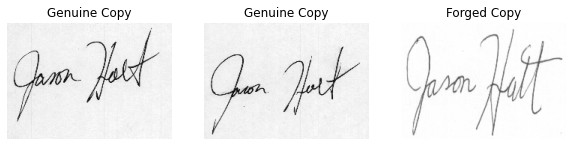

In [ ]:
visualize_sample_signature()

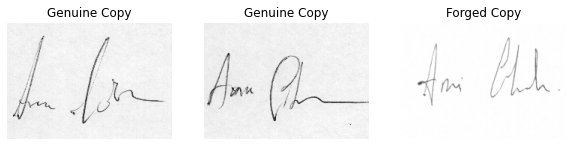

In [ ]:
visualize_sample_signature()

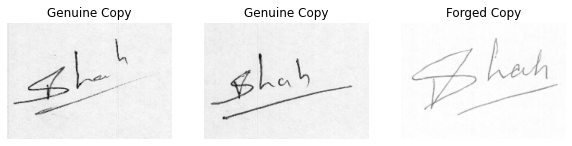

In [ ]:
visualize_sample_signature()

In [ ]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
        # Total number of Genuine-Forged pairs = 120 * 300 = 36000
        # Total no. of data points = 33120 + 36000 = 69120
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            if "forgeries" in pair[0]:
                img1 = cv2.imread(path_CEDAR+"full_forg/" +pair[0], 0)
            elif "original" in pair[0]:
                img1 = cv2.imread(path_CEDAR+"full_org/" +pair[0], 0)
            else :
                img1=cv2.imread(pair[0],0)
            if "forgeries" in pair[1]:
                img2 = cv2.imread(path_CEDAR+"full_forg/" +pair[1], 0)
            elif "original" in pair[1]:
                img2 = cv2.imread(path_CEDAR+"full_org/" +pair[1], 0)
            else :
                img2=cv2.imread(pair[1],0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [ ]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [ ]:
def eucl_dist_output_shape(shapes):    
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [ ]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        init='glorot_uniform', dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(BatchNormalization(epsilon=1e-06, mode=0, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, init='glorot_uniform',  dim_ordering='tf'))
    seq.add(ZeroPadding2D((1, 1), dim_ordering='tf'))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, init='glorot_uniform', dim_ordering='tf'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, W_regularizer=l2(0.0005), activation='relu', init='glorot_uniform')) # softmax changed to relu
    
    return seq

In [ ]:
input_shape=(img_h, img_w, 1)

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, kernel_size=(11, 11), activation="relu", name="conv1_1", strides=4, input_shape=(155, 220,..., data_format="channels_last", kernel_initializer="glorot_uniform")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D((2, 2), data_format="channels_last")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, kernel_size=(5, 5), activation="relu", name="conv2_1", strides=1, data_format="channels_last", kernel_initializer="glorot_uniform")`
  # This is 

In [ ]:
batch_sz = 128
num_train_samples = 276*120 + 300*120
num_val_samples = num_test_samples = 276*20 + 300*20
num_train_samples, num_val_samples, num_test_samples

(69120, 11520, 11520)

In [ ]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

In [ ]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/My Drive/projetCassiopee/Weights/CEDAR/CEDAR-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [ ]:
results = model.fit_generator(generate_batch(orig_train_CEDAR, forg_train_CEDAR, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val_CEDAR, forg_val_CEDAR, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/100
540/540 [==============================] - 523s 968ms/step - loss: 0.9924 - val_loss: 0.3746

Epoch 00001: saving model to /content/drive/My Drive/projetCassiopee/Weights/CEDAR/CEDAR-001.h5
Epoch 2/100
540/540 [==============================] - 515s 953ms/step - loss: 0.1576 - val_loss: 0.1536

Epoch 00002: saving model to /content/drive/My Drive/projetCassiopee/Weights/CEDAR/CEDAR-002.h5
Epoch 3/100
540/540 [==============================] - 506s 936ms/step - loss: 0.0757 - val_loss: 0.0428

Epoch 00003: saving model to /content/drive/My Drive/projetCassiopee/Weights/CEDAR/CEDAR-003.h5
Epoch 4/100
540/540 [==============================] - 498s 922ms/step - loss: 0.0580 - val_loss: 0.0341

Epoch 00004: saving model to /content/drive/My Drive/projetCassiopee/Weights/CEDAR/CEDAR-004.h5
Epoch 5/100
540/540 [==============================] - 484s 896ms/step - loss: 0.0387 - val_loss: 0.0328

Epoch 00005: saving model to /content/drive/My Drive/projetCassiopee/Weights/CEDAR/CED

KeyboardInterrupt: ignored

In [ ]:
Epochs=[i for i in range(1,15)]
loss_CEDAR=[0.9924, 0.1576, 0.0757, 0.0580, 0.0387, 0.0283, 0.0250, 0.0212, 0.0171, 0.0191, 0.046, 0.0164, 0.0092, 0.0123]
val_accuracy_CEDAR= [0.626, 0.8486, 0.96, 0.976, 0.973, 0.914, 0.465, 0.997,0.9259, 0.5444, 0.9951, 0.9186, 0.6086, 0.9197 ]

 ### **Variation of the loss function compared to the epochs**

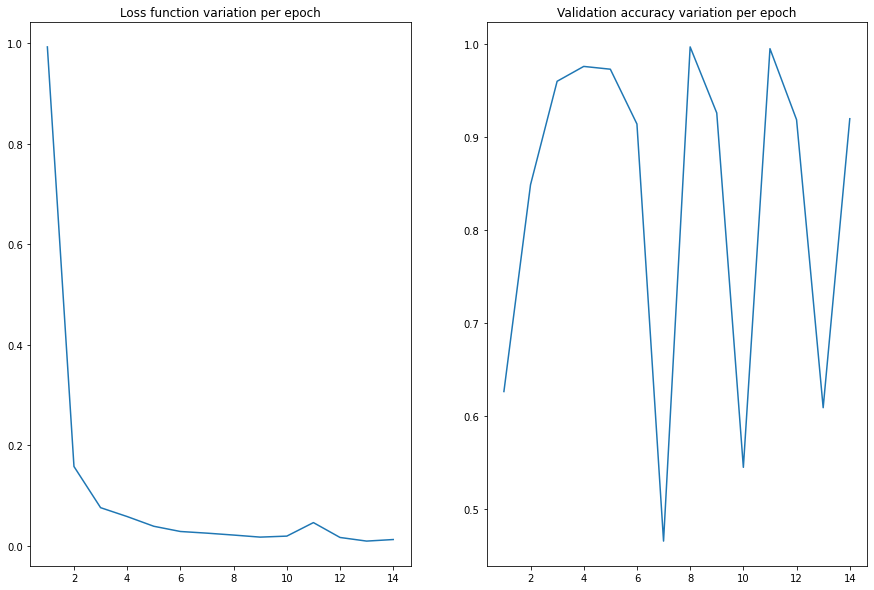

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))
ax1.plot(Epochs, loss_CEDAR)
ax2.plot(Epochs, val_accuracy_CEDAR)
ax1.set_title('Loss function variation per epoch')
ax2.set_title('Validation accuracy variation per epoch')
plt.show()

In [ ]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    max_tpr = 0
    max_tnr = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
            max_tnr = tnr
            max_tpr = tpr
           
    return max_acc, best_thresh, max_tpr, max_tnr;

## **Testing on CEDAR dataset**

In [ ]:
#Load the weights from the epoch which gave the best validation accuracy
model.load_weights('/content/drive/My Drive/projetCassiopee/Weights/CEDAR/CEDAR-009.h5')

In [ ]:
test_gen_CEDAR = generate_batch(orig_test_CEDAR, forg_test_CEDAR, 1)
pred_CEDAR, tr_y_CEDAR = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen_CEDAR)
    tr_y_CEDAR.append(label)
    pred_CEDAR.append(model.predict([img1, img2])[0][0])

In [ ]:
tr_acc, threshold, tpr_CEDAR, tnr_CEDAR = compute_accuracy_roc(np.array(pred_CEDAR), np.array(tr_y_CEDAR))
tr_acc, threshold, tpr_CEDAR, tnr_CEDAR

(1.0, 0.0, 1.0, 1.0)

### **ROC Curve of the CEDAR dataset**

In [ ]:
# Roc curve for Hindi tests
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc

fpr, tpr, thresholds_h = roc_curve(tr_y_CEDAR, pred_CEDAR)
roc_auc = auc(fpr, tpr)
roc_auc_tr = 1 - roc_auc

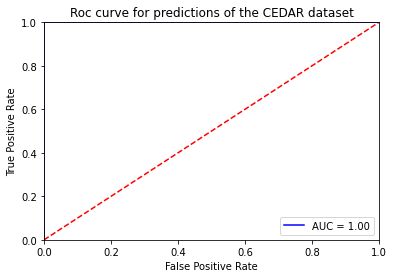

In [ ]:
## Plot the roc curve for CEDAR tests
plt.title('Roc curve for predictions of the CEDAR dataset')
plt.plot(tpr, fpr, 'b', label = 'AUC = %0.2f' % roc_auc_tr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#function for sample results
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen_CEDAR)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

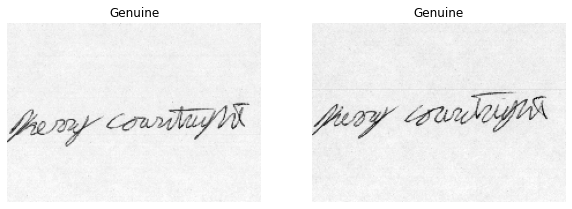

Difference Score =  0.241139
Its a Genuine Signature


In [ ]:
predict_score()

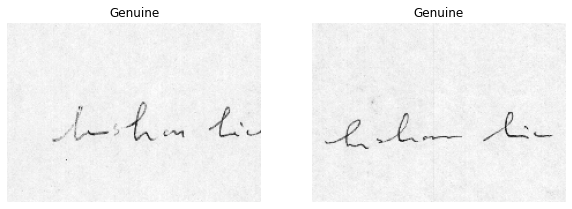

Difference Score =  0.0
Its a Genuine Signature


In [ ]:
predict_score()

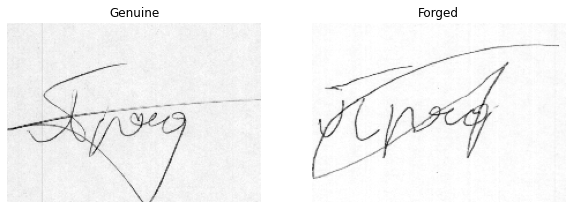

Difference Score =  9.880998
Its a Forged Signature


In [ ]:
predict_score()

## **Testing on GPDS dataset**

In [ ]:
# Get the list of all directories and sort them
dir_list_GPDS = next(os.walk(path_GPDS))[1]
dir_list_GPDS.sort()

In [ ]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups_GPDS, forg_groups_GPDS = [], []
for directory in dir_list_GPDS:
    images = os.listdir(path_GPDS+directory)
    images.sort()
    images = [path_GPDS+directory+'/'+x for x in images]
    forg_groups_GPDS.append(images[:30]) # First 30 signatures in each folder are forged
    orig_groups_GPDS.append(images[30:]) # Next 24 signatures are genuine

In [ ]:
# Quick check to confirm we have data of all the 300 individuals
len(orig_groups_GPDS), len(forg_groups_GPDS)

(300, 300)

In [ ]:
orig_test_GPDS = orig_groups_GPDS[280:]
forg_test_GPDS = forg_groups_GPDS[280:]

In [ ]:
# Delete unnecessary variables
del orig_groups_GPDS, forg_groups_GPDS

In [ ]:
#Load the weights from the epoch which gave the best validation accuracy
model.load_weights('/content/drive/My Drive/projetCassiopee/Weights/CEDAR/CEDAR-009.h5')

In [ ]:
test_gen_GPDS = generate_batch(orig_test_GPDS, forg_test_GPDS, 1)
pred_GPDS, tr_y_GPDS = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen_GPDS)
    tr_y_GPDS.append(label)
    pred_GPDS.append(model.predict([img1, img2])[0][0])

In [ ]:
tr_acc_GPDS, threshold_GPDS, tpr_GPDS,tnr_GPDS = compute_accuracy_roc(np.array(pred_GPDS), np.array(tr_y_GPDS))
tr_acc_GPDS, threshold_GPDS, tpr_GPDS, tnr_GPDS

(0.5243388980272309, 1.46, 0.35923363491218735, 0.6894441611422744)

### **ROC Curve of the GPDS dataset**

In [ ]:
# Roc curve for GPDS tests

fpr_GPDS_roc, tpr_GPDS_roc, thresholds_G = roc_curve(tr_y_GPDS, pred_GPDS)
roc_auc_GPDS = auc(fpr_GPDS_roc, tpr_GPDS_roc)
auc_score_GPDS = roc_auc_score(tr_y_GPDS, pred_GPDS)
roc_auc_GPDS_tr = 1 - roc_auc_GPDS
roc_auc_GPDS, auc_score_GPDS

(0.4753306229804166, 0.4753306229804166)

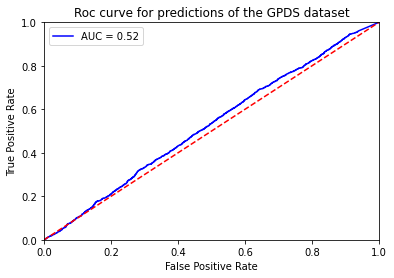

In [ ]:
## Plot the roc curve for GPDS tests
plt.title('Roc curve for predictions of the GPDS dataset')
plt.plot(tpr_GPDS_roc, fpr_GPDS_roc, 'b', label = 'AUC = %0.2f' % roc_auc_GPDS_tr)
plt.legend(loc = 'best')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#function for sample results
def predict_score_GPDS():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen_GPDS)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold_GPDS:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

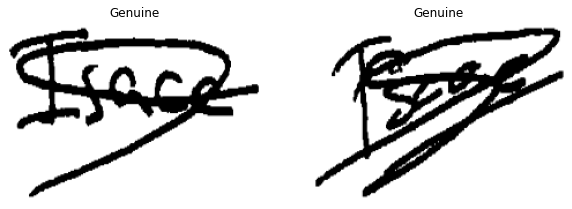

Difference Score =  5.7451262
Its a Forged Signature


In [ ]:
predict_score_GPDS()

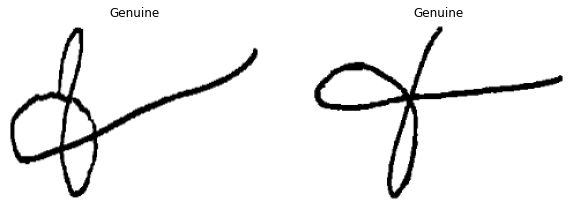

Difference Score =  3.3340516
Its a Genuine Signature


In [ ]:
predict_score_GPDS()

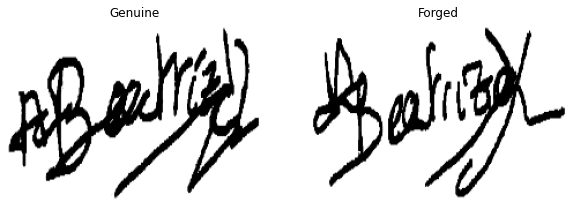

Difference Score =  0.20175312
Its a Genuine Signature


In [ ]:
predict_score_GPDS()

### **Plotting the ROC Curve of the CEDAR and GPDS datasets**

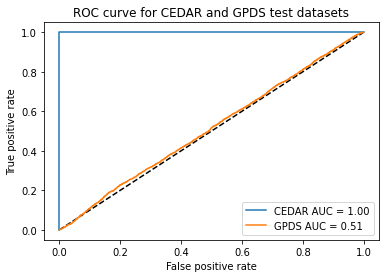

In [ ]:
### Roc curve for the CEDAR tests and GPDS tests

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(tpr, fpr, label='CEDAR AUC = %0.2f'% roc_auc_tr)
plt.plot(tpr_GPDS_roc, fpr_GPDS_roc, label='GPDS AUC = %0.2f'% roc_auc_GPDS_tr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for CEDAR and GPDS test datasets')
plt.legend(loc='best')
plt.show()

## **Testing on the BHSIG260 Hindi dataset**

In [ ]:
# Path to BHSig260 Hindi dataset
path_Hindi = "/content/drive/My Drive/projetCassiopee/BHSig260/Hindi/"

In [ ]:
# Get the list of all directories and sort them
dir_list_Hindi = next(os.walk(path_Hindi))[1]
dir_list_Hindi.sort()

In [ ]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups_Hindi, forg_groups_Hindi = [], []
for directory in dir_list_Hindi:
    images = os.listdir(path_Hindi+directory)
    images.sort()
    images = [path_Hindi+directory+'/'+x for x in images]
    forg_groups_Hindi.append(images[24:]) # First 30 signatures in each folder are forged
    orig_groups_Hindi.append(images[:24]) # Next 24 signatures are genuine

In [ ]:
orig_lengths_Hindi = [len(x) for x in orig_groups_Hindi]
forg_lengths_Hindi = [len(x) for x in forg_groups_Hindi]

In [ ]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths_Hindi)
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths_Hindi)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30

In [ ]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups_Hindi), len(forg_groups_Hindi)

(160, 160)

In [ ]:
orig_test_Hindi = orig_groups_Hindi[140:]
forg_test_Hindi = forg_groups_Hindi[140:]

In [ ]:
# Delete unnecessary variables
del orig_groups_Hindi, forg_groups_Hindi

In [ ]:
#Load the weights from the epoch which gave the best validation accuracy
model.load_weights('/content/drive/My Drive/projetCassiopee/Weights/CEDAR/CEDAR-009.h5')

In [ ]:
test_gen_Hindi = generate_batch(orig_test_Hindi, forg_test_Hindi, 1)
pred_Hindi, tr_y_Hindi = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen_Hindi)
    tr_y_Hindi.append(label)
    pred_Hindi.append(model.predict([img1, img2])[0][0])

In [ ]:
tr_acc_Hindi, threshold_Hindi,tpr_Hindi, tnr_Hindi = compute_accuracy_roc(np.array(pred_Hindi), np.array(tr_y_Hindi))
tr_acc_Hindi, threshold_Hindi, tpr_Hindi, tnr_Hindi

(0.5644558578175696,
 3.8000000000000003,
 0.6238044633368757,
 0.5051072522982636)

### **ROC Curve for the Hindi datasets**

In [ ]:
# Roc curve for Hindi tests

fpr_Hindi_roc, tpr_Hindi_roc, threshold_H = roc_curve(tr_y_Hindi, pred_Hindi)
roc_auc_Hindi = auc(fpr_Hindi_roc, tpr_Hindi_roc)
auc_score_Hindi = roc_auc_score(tr_y_Hindi, pred_Hindi)
auc_score_Hindi_tr = 1 - auc_score_Hindi
auc_score_Hindi, roc_auc_Hindi, auc_score_Hindi_tr

(0.407894799527834, 0.407894799527834, 0.5921052004721661)

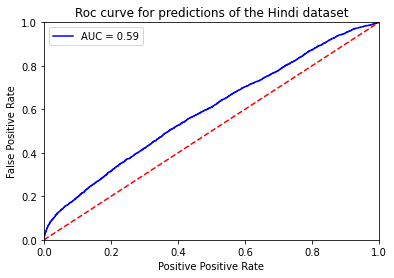

In [ ]:
## Plot the roc curve for Hindi tests
plt.title('Roc curve for predictions of the Hindi dataset')
plt.plot(tpr_Hindi_roc, fpr_Hindi_roc, 'b', label = 'AUC = %0.2f' % auc_score_Hindi_tr)
plt.legend(loc = 'best')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('False Positive Rate')
plt.xlabel('Positive Positive Rate')
plt.show()

In [ ]:
#function for sample results
def predict_score_Hindi():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen_Hindi)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold_Hindi:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

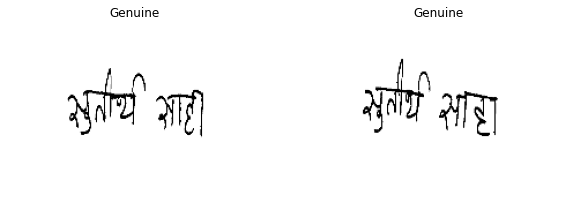

Difference Score =  2.1052
Its a Genuine Signature


In [ ]:
predict_score_Hindi()

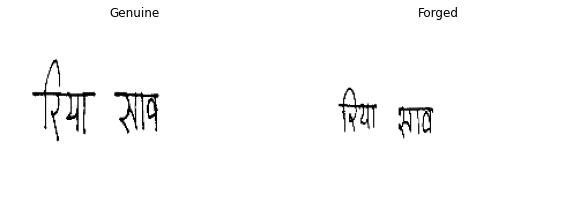

Difference Score =  12.380239
Its a Forged Signature


In [ ]:
predict_score_Hindi()

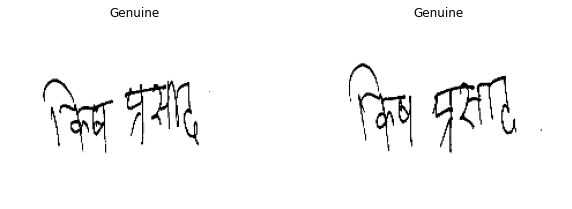

Difference Score =  0.727322
Its a Genuine Signature


In [ ]:
predict_score_Hindi()

## **Testing on the BHSIG260 Bengali dataset**


In [ ]:
# Path to BHSig260 Bengali dataset
path_Bengali = "/content/drive/My Drive/projetCassiopee/BHSig260/Bengali/"

In [ ]:
# Get the list of all directories and sort them
dir_list_Bengali = next(os.walk(path_Bengali))[1]
dir_list_Bengali.sort()

In [ ]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups_Bengali, forg_groups_Bengali = [], []
for directory in dir_list_Bengali:
    images = os.listdir(path_Bengali+directory)
    images.sort()
    images = [path_Bengali+directory+'/'+x for x in images]
    forg_groups_Bengali.append(images[24:]) # First 30 signatures in each folder are forged
    orig_groups_Bengali.append(images[:24]) # Next 24 signatures are genuine

In [ ]:
orig_lengths_Bengali = [len(x) for x in orig_groups_Bengali]
forg_lengths_Bengali = [len(x) for x in forg_groups_Bengali]

In [ ]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths_Bengali)
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths_Bengali)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


In [ ]:
# Quick check to confirm we have data of all the 100 individuals
len(orig_groups_Bengali), len(forg_groups_Bengali)

(100, 100)

In [ ]:
orig_test_Bengali = orig_groups_Bengali[80:]
forg_test_Bengali = forg_groups_Bengali[80:]

In [ ]:
# Delete unnecessary variables
del orig_groups_Bengali, forg_groups_Bengali

In [ ]:
#Load the weights from the epoch which gave the best validation accuracy
model.load_weights('/content/drive/My Drive/projetCassiopee/Weights/CEDAR/CEDAR-009.h5')

In [ ]:
test_gen_Bengali = generate_batch(orig_test_Bengali, forg_test_Bengali, 1)
pred_Bengali, tr_y_Bengali = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen_Bengali)
    tr_y_Bengali.append(label)
    pred_Bengali.append(model.predict([img1, img2])[0][0])

In [ ]:
tr_acc_Bengali, threshold_Bengali, tpr_Bengali, tnr_Bengali = compute_accuracy_roc(np.array(pred_Bengali), np.array(tr_y_Bengali))
tr_acc_Bengali, threshold_Bengali, tpr_Bengali, tnr_Bengali

(0.5885041513492051, 4.04, 0.7688762850053172, 0.4081320176930929)

### **ROC Curve for the Bengali tests**

In [ ]:
# Roc curve for Bengali tests

fpr_Bengali_roc, tpr_Bengali_roc, threshold_B = roc_curve(tr_y_Bengali, pred_Bengali)
roc_auc_Bengali = auc(fpr_Bengali_roc, tpr_Bengali_roc)
auc_score_Bengali = roc_auc_score(tr_y_Bengali, pred_Bengali)
auc_score_Bengali_tr = 1 - auc_score_Bengali
auc_score_Bengali, roc_auc_Bengali, auc_score_Bengali_tr

(0.38326000109276187, 0.38326000109276187, 0.6167399989072382)

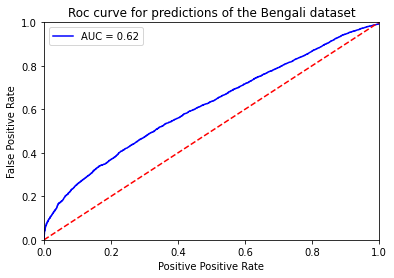

In [ ]:
## Plot the roc curve for Bengali tests
plt.title('Roc curve for predictions of the Bengali dataset')
plt.plot(tpr_Bengali_roc, fpr_Bengali_roc, 'b', label = 'AUC = %0.2f' % auc_score_Bengali_tr)
plt.legend(loc = 'best')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('False Positive Rate')
plt.xlabel('Positive Positive Rate')
plt.show()

In [ ]:
#function for sample results
def predict_score_Bengali():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen_Bengali)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold_Bengali:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

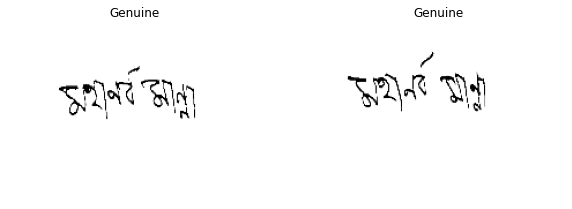

Difference Score =  3.5860748
Its a Genuine Signature


In [ ]:
predict_score_Bengali()

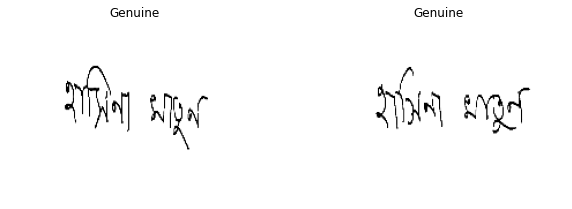

Difference Score =  0.11437346
Its a Genuine Signature


In [ ]:
predict_score_Bengali()

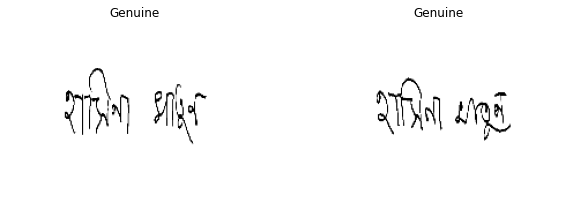

Difference Score =  3.8287241
Its a Forged Signature


In [ ]:
predict_score_Bengali()

## **Plotting ROC Curve for all the test datasets**


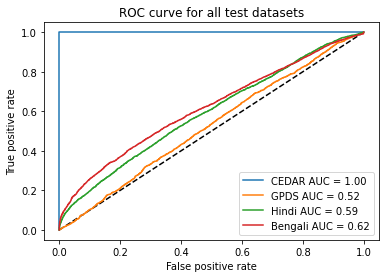

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(tpr, fpr, label='CEDAR AUC = %0.2f'% roc_auc_tr)
plt.plot(tpr_GPDS_roc, fpr_GPDS_roc, label='GPDS AUC = %0.2f'% roc_auc_GPDS_tr)
plt.plot(tpr_Hindi_roc, fpr_Hindi_roc, label='Hindi AUC = %0.2f'% auc_score_Hindi_tr)
plt.plot(tpr_Bengali_roc, fpr_Bengali_roc, label='Bengali AUC = %0.2f'% auc_score_Bengali_tr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for all test datasets')
plt.legend(loc='best')
plt.show()